# Visualizing Performance

To make this more interesting, we are going to consider a more challenging problem.
We will looking at how to visualize two competing implementations.

### Build a Bigger CQM

In [60]:
from dimod import ConstrainedQuadraticModel
import random

# Set size parameter. Model will have n^2 variables.
n=35

# Instantiate CQM and add grid of variables
old_cqm = ConstrainedQuadraticModel()
old_cqm.add_variables('BINARY', [(a,b) for a in range(n) for b in range(n)])

# Add psuedorandom dense objective.
random.seed(1)
old_cqm.set_objective([(v,w,random.randint(5,20)) for v in old_cqm.variables for w in old_cqm.variables])

# Add assignment constraint.
for i in range(n):
    old_cqm.add_constraint_from_iterable([((i,j), 1) for j in range(n)], '==', rhs=1, label=f'({i},*)')
    old_cqm.add_constraint_from_iterable([((j,i), 1) for j in range(n)], '==', rhs=1, label=f'(*, {i})')


# Instantiate CQM and add grid of variables
new_cqm = ConstrainedQuadraticModel()
new_cqm.add_variables('BINARY', [(a,b) for a in range(n) for b in range(n)])

# Add psuedorandom dense objective.
random.seed(1)
new_cqm.set_objective([(v,w,random.randint(5,20)) for v in new_cqm.variables for w in new_cqm.variables])


# Add assignment constraint.
for i in range(n):
    new_cqm.add_discrete([(i,j) for j in range(n)], label=f'({i},*)')
    new_cqm.add_constraint_from_iterable([((j,i), 1) for j in range(n)], '==', rhs=1, label=f'(*, {i})')
    
print('Number of Variables:', len(old_cqm.variables), len(new_cqm.variables))

Number of Variables: 1225 1225


### Get two samplesets by submitting the CQMs to the solver

In [4]:
from dwave.system import LeapHybridCQMSampler

cqm_sampler = LeapHybridCQMSampler()

old_sampleset = cqm_sampler.sample_cqm(old_cqm, time_limit=5)
new_sampleset = cqm_sampler.sample_cqm(new_cqm, time_limit=5)

#### Filter for the best feasible samples - where all hard constraints are satisfied.

In [8]:
feasible_sampleset = old_sampleset.filter(lambda d:d.is_feasible)

print('# Samples:', len(sampleset))
print('# Feasible:', len(feasible_sampleset), "\n")

# Samples: 91
# Feasible: 55 



In [9]:
# The best feasible solution found is
best = feasible_sampleset.first

print("Sample energy: ", best.energy, "\n")

print("Are all constraints satisfied? ", best.is_feasible)

Sample energy:  10019.0 

Are all constraints satisfied?  True


## Quick and useful charts for distributions

In [25]:
# As a Pandas dataframe
dataframe = feasible_sampleset.to_pandas_dataframe(True)

array([[<AxesSubplot:title={'center':'energy'}>]], dtype=object)

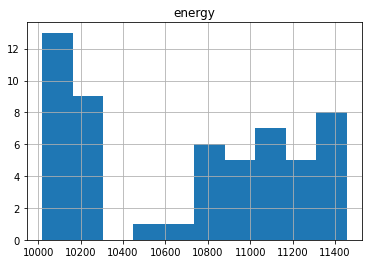

In [26]:
dataframe.hist('energy')

<AxesSubplot:>

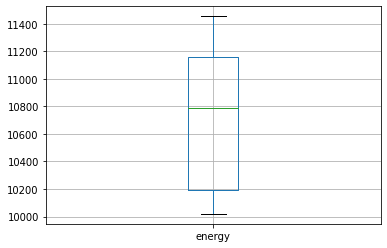

In [27]:
dataframe.boxplot('energy')

## Visualizing Comparisons

Next, we try to make more meaningful (and readible) charts to help us compare two approaches.

In [28]:
# MatPlotLib is commonly used for charting in python
import matplotlib.pyplot as plt

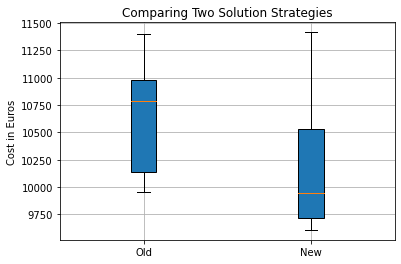

In [37]:
# Compare the two methods
feasible_sampleset = sampleset.filter(lambda d:d.is_feasible)
new_feasible_sampleset = new_sampleset.filter(lambda d:d.is_feasible)

old_energies = feasible_sampleset.data_vectors['energy']
new_energies = new_feasible_sampleset.data_vectors['energy']

# old_energies = feasible_sampleset.to_pandas_dataframe(True).energy
# new_energies = new_feasible_sampleset.to_pandas_dataframe(True).energy

plt.boxplot([old_energies, new_energies], patch_artist=True, labels=['Old', 'New'])

plt.grid()
plt.title('Comparing Two Solution Strategies')
plt.ylabel('Cost in Euros')
plt.show()


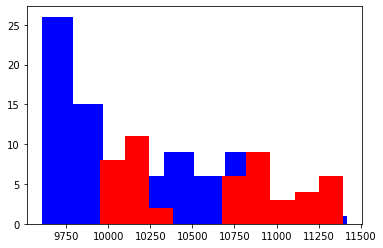

In [43]:
# Fast Histogram Comparison
plt.hist(new_energies, color = 'blue')
plt.hist(old_energies, color = 'red')
plt.show()

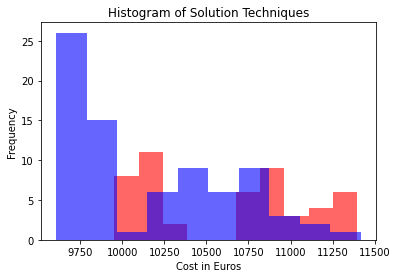

In [53]:
# Better histogram comparison
plt.hist(df_old.energy, color='red', alpha=0.6)
plt.hist(df_new.energy, color='blue', alpha=0.6)


plt.title('Histogram of Solution Techniques')
plt.xlabel('Cost in Euros')
plt.ylabel('Frequency')

plt.show()

## Visualizing Performance over Time

Most of the time, we just want the best solution. 
However, the quality can depend on how much time we have.
To make things harder, heuristics solutions are not consistent.

The burndown charts below  are a good approach to this situation.

In [114]:
# Function for getting best solution at different times.
def burndown_data(model, times):
    best_energies = []
    for time in times:
        samples = cqm_sampler.sample_cqm(model, time_limit=time)
        feasible = samples.filter(lambda d: d.is_feasible)
        best_energies.append(feasible.first.energy)
    return best_energies

In [130]:
# Get best solutions at differet times. Repeat 3 times.
# This will take over 30 minutes.
# times_exp = [5*2**t for t in range(6) for _ in range(3)]
# best_old_energies_exp = burndown_data(old_cqm, times_exp)
# best_new_energies_exp = burndown_data(new_cqm, times_exp)

# Save to file, so it does not have to be repeated.
with open('best_old_energies_exp.json', 'w') as f:
    json.dump(best_old_energies_exp, f)
with open('best_new_energies_exp.json', 'w') as f:
    json.dump(best_new_energies_exp, f)
with open('times_exp.json', 'w') as f:
    json.dump(times_exp, f)

In [122]:
# Load burndown data from file.
with open('best_old_energies_exp.json', 'rb') as f:
    best_old_energies_exp = json.load(f)
with open('best_new_energies_exp.json', 'rb') as f:
    best_new_energies_exp = json.load(f)
with open('times_exp.json', 'rb') as f:
    times_exp = json.load(f)

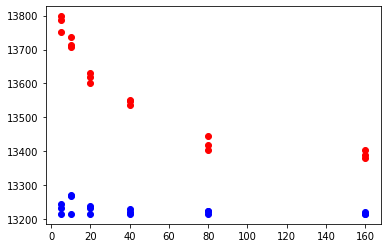

In [129]:
# A quick scatter plot.
plt.scatter(times_exp, best_old_energies_exp, color = 'red')
plt.scatter(times_exp, best_new_energies_exp, color = 'blue')
plt.show()

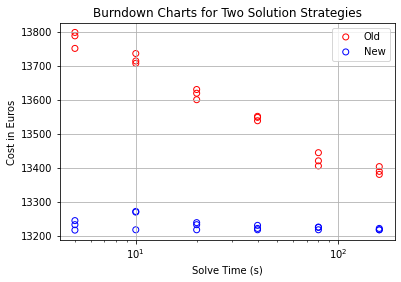

In [132]:
# A nicer scatter plot.
plt.scatter(times_exp, best_old_energies_exp, color = 'red', facecolors='none', label='Old')
plt.scatter(times_exp, best_new_energies_exp, color = 'blue', facecolors='none', label='New')

plt.grid()
plt.title('Burndown Charts for Two Solution Strategies')
plt.xlabel('Solve Time (s)')
plt.ylabel('Cost in Euros')
plt.xscale('log')
plt.legend()

plt.show()